In [1]:
import numpy as np
import PIL
import random
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import copy

def ripple_from_color(image, color, distance, width):
    color_1 = (255,255,255,255)
    color_2=(0,0,0,0)
    circles_1 = Image.new("RGBA", (image.size[0], image.size[1]), (0,0,0,0))
    
    draw_circles_1 = ImageDraw.Draw(circles_1, "RGBA")
    
    data = np.asarray(image)
    array = np.array([ [(j == [color[0],color[1], color[2]]).all() for j in i] for i in data])
    
    for y in range(len(array)):
        for x in range(len(array[0])):
            if array[y][x] == True:
                draw_circles_1.ellipse((x-distance, y-distance, x+distance, y+distance), fill=color_1)
    for y in range(len(array)):
        for x in range(len(array[0])):
            if array[y][x] == True:
                draw_circles_1.ellipse((x-distance+width, y-distance+width, x+distance-width, y+distance-width), fill=color_2)
    ripple_color = Image.new("RGB", (image.size[0], image.size[1]), color)
    image.paste(ripple_color, (0,0), circles_1)
    return image

## First Create a function that has two main inputs, a list of tuples called start_points (coordinate, connections)
## the second input should be a list (ideally sorted in some way) of points of size sum(connections)
## Input image is a PIL Image object whose size allows for the inclusion of the points givenin start_points and end_points
## Draw lines between these points in the given image
def connect_bolts(start_points, end_points, image, color, line_width):
    draw = ImageDraw.Draw(image)
    for point in start_points:
        #point is a tuple (coordinate, connections)
        for i in range(point[1]):
            #Line inputs are [pt_1,pt_2], fill, width
            draw.line([point[0], end_points[0]], fill = color, width = line_width)
            end_points = end_points[1:]

#Take an input of a list coordinates and determine how many connections it will have based on a input probability list
# return a list containing tuples (coordinate, num_connections)
def split_decider(coordinates, probability):
    start_pts = []
    for coord in coordinates:
        num_connections = random.choice(probability)
        start_pts.append((coord, num_connections))
    return start_pts

# Now something a little more specific to my goals: create a list of points a specific x-distance away, organized by their y-value
#  smallest to largest where the number of points created is the sum of the number of connections from my start_pt list
#    y_range is a tuple (begin, end)
def create_end_pts(start_pts, x_step, y_range):
    num_pts = 0
    x = start_pts[0][0][0] + int(x_step)
    end_pts = []
    for coord_num in start_pts:
        num_pts += coord_num[1]
    y_coords = []
    for i in range(num_pts):
        y = random.randint(y_range[0], y_range[1])
        y_coords.append(y)
    y_coords.sort()
    for y in y_coords:
        end_pts.append((x,y))
    return end_pts

## Lets put it all together with creating an image, with a number of iterations, an initial width, height and all the needed inputs for
##   for the previously made functions
def lightning_bolt_1(height, init_width, iterations, color, probability, fractional_diminish):
    #Determine the width of the image
    image_width = int(init_width)
    temp_width = int(init_width)
    for i in range(iterations):
        temp_width = int(temp_width*fractional_diminish)
        image_width += temp_width
    #Initiate Image
    image = Image.new("RGBA", (image_width,height))
    
    #Starting point
    start_pts = [(0, int(height/2))]
    
    # Initial values
    line_width = int(iterations)
    x_step = int(init_width)
    y_range = (0, image.height)
    color = (255,255,255,255)
    
    #Where the lightning happens
    for i in range(iterations+1):
        split_form = split_decider(start_pts,probability)
        end_pts = create_end_pts(split_form, x_step, y_range)
        connect_bolts(split_form, end_pts, image, color, line_width)
        start_pts = end_pts
        line_width = line_width-1
        x_step = int(x_step*fractional_diminish)
    return image

# NOTE THE INPUTS OMIT COLOR OF BOLT AS THAT WILL BE CHANGING BUT NEED TO MAKE SURE IT IS WHITE
def color_bolt(color1, color2, height, init_width, iterations, probability, fractional_diminish):
    bolt = lightning_bolt_1(height, init_width, iterations, (255,255,255), probability, fractional_diminish)
    gradient = generate_gradient(color1, color2, bolt.width, bolt.height)
    image = Image.new("RGBA", (bolt.width, bolt.height), (0,0,0,0))
    image.paste(gradient, (0,0), bolt)
    return image

# image must be of object type PIL.Image, coordinate must be an ordered (x,y) tuple, rotation given in degrees
# returns the location of the new point
def location_of_new_point(image, coordinate, rotation):
    x = coordinate[0]
    y = coordinate[1]
    rotated_image = image.rotate(rotation, resample = PIL.Image.NEAREST, expand = True)
    
    if rotation <= 90:
        theta = rotation*(np.pi/180)
        x_new = int( y*np.sin(theta) + x*np.cos(theta) )
        y_new = int( image.width *np.sin(theta) + y*np.cos(theta) - x* np.sin(theta) )
        location = (x_new, y_new)
        return location
    
    if (rotation >90) and (rotation<=180):
        rotation = rotation - 90
        theta = rotation*(np.pi/180)
        x_new = int( image.width*np.sin(theta) + y*np.cos(theta) - x*np.sin(theta) )
        y_new = int( rotated_image.height - y*np.sin(theta) - x*np.cos(theta) )
        location = (x_new, y_new)
        return location
    
    if (rotation > 180) and (rotation <=270):
        rotation = rotation - 180
        theta = rotation*(np.pi/180)
        x_new = int((image.height-y)*np.sin(theta) + (image.width - x)* np.cos(theta))
        y_new = int(image.width * np.sin(theta) + (image.height - y)*np.cos(theta) - (image.width - x)* np.sin(theta))
        location = (x_new, y_new)
        return location
        
    if (rotation > 270) and (rotation <=360):
        rotation = rotation - 270
        theta = rotation*(np.pi/180)
        x_new = int( image.height * np.cos(theta) - y * np.cos(theta) + x * np.sin(theta) )
        y_new = int(y * np.sin(theta) + x * np.cos(theta))
        location = (x_new, y_new)
        return location

def generate_gradient(color1, color2, width: int, height: int):
    ###Generate a vertical gradient
    ## Create a base image of color 1
    base = Image.new('RGB', (width, height), color1)
    ## Create a top image of color 2
    top = Image.new('RGB', (width, height), color2)
    ## Initiate a mask, and initiate a list that will contain it's data
    mask = Image.new('L', (width, height))
    mask_data = []
    for y in range(height):
        for x in range(width):
            mask_data.append(int(255 * (x / width)))
    # mask_data is now a list of integers from 0 to 255 of length height x width so we can put it as thr data for mask
    mask.putdata(mask_data)
    #paste the top on the base but use mask as transparency
    base.paste(top, (0, 0), mask)
    return base

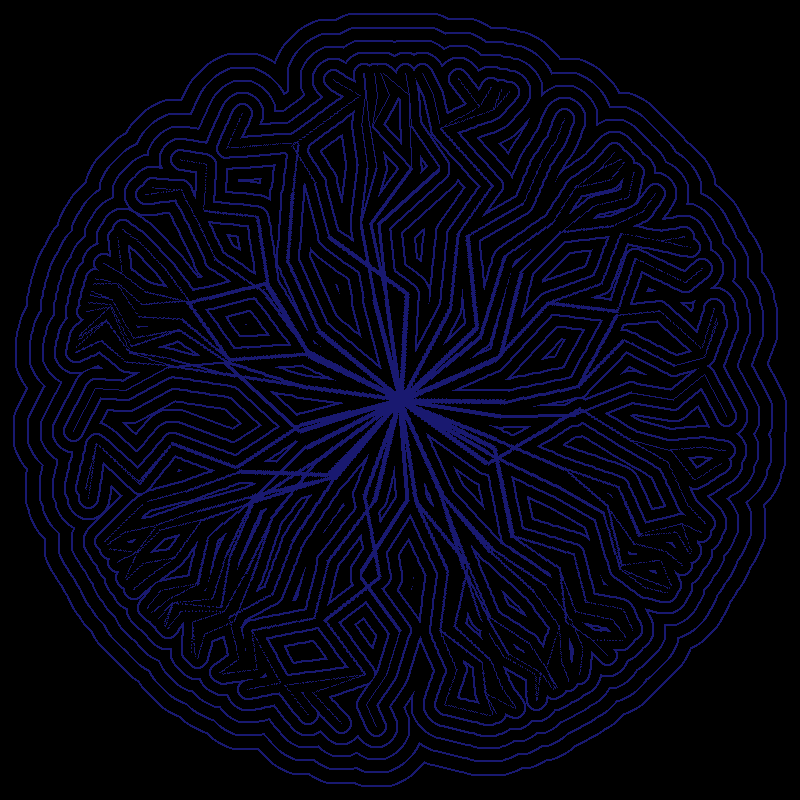

In [2]:
#Ball Lightning
image = Image.new("RGB", (800,800), (0,0,0,255))
draw = ImageDraw.Draw(image)
color1 = (25,25,112)
color2 = (25,25,112)
height = 80
init_width = 100
iterations = 5
probability = [1,1,1,2]
fractional_diminish = float(6/8)
theta = 0
center = (int(image.width/2), int(image.height/2))

while theta < 360:
    bolt = color_bolt(color1, color2, height, init_width, iterations, probability, fractional_diminish)
    bolt_center = (0, int(bolt.height/2))
    center_move = location_of_new_point(bolt, bolt_center, theta)
    bolt = bolt.rotate(theta, resample = PIL.Image.NEAREST, expand = True)
    paste_point = (center[0] - center_move[0], center[1] - center_move[1])
    image.paste(bolt, paste_point, bolt)
    theta += 15

for i in range(5):
    image = ripple_from_color(image, color1, distance=10+i, width=2)
image

In [9]:
#Ball Lightning Ripple colored white for use as a mask
image_1 = Image.new("RGB", (800,800), (0,0,0))
draw = ImageDraw.Draw(image_1)
color1 = (255,255,255)
color2 = (255,255,255)
height = 80
init_width = 100
iterations = 5
probability = [1,1,1,2]
fractional_diminish = float(6/8)
theta = 0
center = (int(image_1.width/2), int(image_1.height/2))

while theta < 360:
    bolt = color_bolt(color1, color2, height, init_width, iterations, probability, fractional_diminish)
    bolt_center = (0, int(bolt.height/2))
    center_move = location_of_new_point(bolt, bolt_center, theta)
    bolt = bolt.rotate(theta, resample = PIL.Image.NEAREST, expand = True)
    paste_point = (center[0] - center_move[0], center[1] - center_move[1])
    image_1.paste(bolt, paste_point, bolt)
    theta += 15

for i in range(5):
    image_1 = ripple_from_color(image_1, color1, distance=10+i, width=2)

image_2 = Image.new("RGB", (800,800), (0,0,0))
draw = ImageDraw.Draw(image_2)
color1 = (255,255,255)
color2 = (255,255,255)
height = 80
init_width = 100
iterations = 5
probability = [1,1,1,2]
fractional_diminish = float(6/8)
theta = 0
center = (int(image_2.width/2), int(image_2.height/2))

while theta < 360:
    bolt = color_bolt(color1, color2, height, init_width, iterations, probability, fractional_diminish)
    bolt_center = (0, int(bolt.height/2))
    center_move = location_of_new_point(bolt, bolt_center, theta)
    bolt = bolt.rotate(theta, resample = PIL.Image.NEAREST, expand = True)
    paste_point = (center[0] - center_move[0], center[1] - center_move[1])
    image_2.paste(bolt, paste_point, bolt)
    theta += 15

for i in range(5):
    image_2 = ripple_from_color(image_2, color1, distance=10+i, width=2)
    
background = Image.new("RGB", (800,800))
color_1 = (0,0,156)
color_2 = (54,117,136)
color_1_background = Image.new("RGB", (800,800),color_1)
color_2_background = Image.new("RGB", (800,800),color_2)
background.paste(color_1_background, (0,0), image_1)
background.paste(color_2_background, (0,0), image_2)
background

ValueError: bad transparency mask

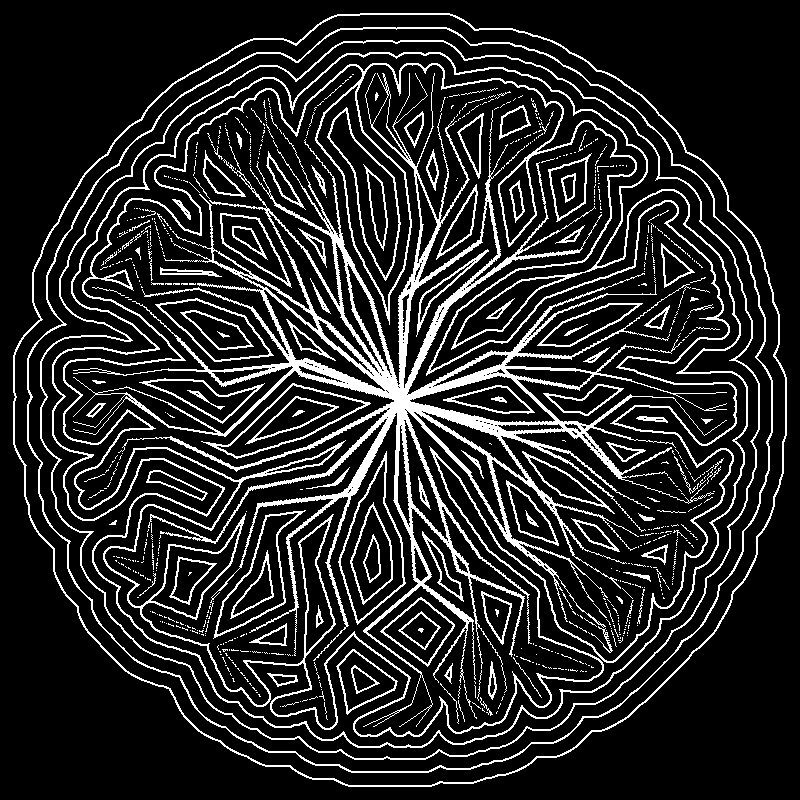

In [10]:
image_1